# EDA

Ниже будет небольшой дескриптинвый анализ данных, используемых для обучения и оценки классификаторов в дальнейшем.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from src.data import *

In [2]:
speakers = pd.read_csv('../data/dev-clean/LibriTTS/speakers.tsv',
                       skiprows=[0],
                       header=None,
                       sep='\t')
speakers.columns = ['id', 'gender', 'subset', 'name']

In [3]:
speakers.head()

,id,gender,subset,name
0,14,F,train-clean-360,Kristin LeMoine
1,16,F,train-clean-360,Alys AtteWater
2,17,M,train-clean-360,Gord Mackenzie
3,19,F,train-clean-100,Kara Shallenberg
4,20,F,train-other-500,Gesine


Каждый говорящий присутствует лишь в каком-то одном из частей датасета (train, dev, test) (значение колонки id говорящего уникальное).

Можем сделать вывод, что, во-первых, у нас не будет утечки данных из трейна в тест или дев, так как каждый говорящий присутствует лишь в какой-то одной части.

In [4]:
print(speakers['id'].unique().shape[0], speakers.shape[0])

2484 2484


## Распределение по полу
Посмотрим на распределение полов в разных частях датасета

In [5]:
speakers.groupby(['subset', 'gender']).count()[['id']]

id
subset          gender     
dev-clean       F        20
                M        20
dev-other       F        16
                M        17
test-clean      F        20
                M        20
test-other      F        17
                M        16
train-clean-100 F       125
                M       126
train-clean-360 F       439
                M       482
train-other-500 F       564
                M       602

Видим, что датасет очень сбалансирован по полу.



## Длительность записей

Посмотрим, на распределение длительности всех сигналов в тренировочной выборке.

In [6]:
train_files = dataset_wav_paths('../data/train-clean-100/LibriTTS/train-clean-100')

In [7]:
import librosa

In [8]:
# все сигналы имеют уровень дискретизации 24кГц
durations = []
for speaker in train_files:
    for sig in train_files[speaker]:
        y, sr = librosa.load(sig, sr=24000)
        durations.append(librosa.get_duration(y=y, sr=sr))

Средняя длительность сигнала

In [9]:
np.mean(durations)

5.82614749819473

(array([1.3066e+04, 9.5740e+03, 5.3850e+03, 2.6880e+03, 1.3590e+03,
        6.6000e+02, 3.1400e+02, 1.3700e+02, 4.2000e+01, 1.1000e+01]),
 array([ 0.16 ,  3.469,  6.778, 10.087, 13.396, 16.705, 20.014, 23.323,
        26.632, 29.941, 33.25 ]),
 <BarContainer object of 10 artists>)

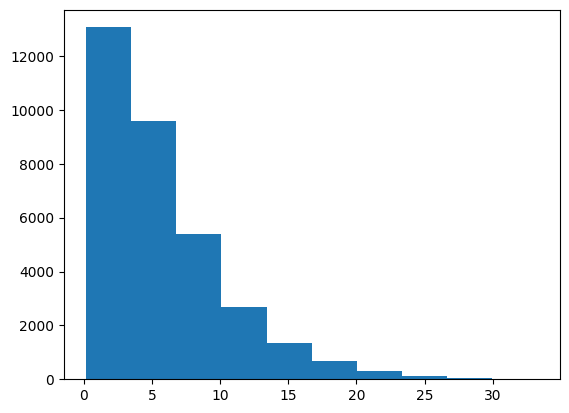

In [10]:
plt.hist(durations)

In [11]:
np.median(durations)

4.54

In [12]:
(np.array(durations)<5).sum()/len(durations), (np.array(durations)<10).sum()/len(durations)

(0.5420327355879168, 0.840564448188711)

В основном, все сигналы короткие, 54% менее 5 секунд, 84% - менее 10. В дальнейшем, буду обрезать все сигналы до единого размера - до 2 секунд, чтобы сэкономить память и вычислительные ресурсы. Кажется, что на классификации голоса на мужской/женский это не должно повлиять, так как в каждом файле записан лишь один голос от одного говорящего.


## Визуализация признаков
Популярным представлением для анализа сигналов являются спектрограммы, в том числе - мел-спектрограммы. Ниже попыталась визуализировать признаки, полученные с помощью подсчета мел-спектрограмм в 2d пространстве с помощью TSNE. Глядя на визуализацию, кажется, что даже при сокращении размерности до 2 (а мел-спектрограмма в вытянутом виде имеет очень большую размерность) можно выделить некоторые группы точек. Это вселяет надежду на качественную классификацию с помощью мел-спектрограмм.

В данном случае мел-спектрограммы были посчитаны следующим образом - каждый сигнал обрезался/дополнялся до 2 секунд, затем для него считалась спектрограмма. Каждая мел-спектрограмма строилась с дефолтными параметрами из пакета librosa, за исключением параметров fmin и fmax, которые были выставлены 20 и 4000 соответственно.


In [13]:
X, y, ids = data_features(train_files, speakers, sr=24000, max_sig_duration=2)

100%|██████████| 247/247 [03:12<00:00,  1.28it/s]


In [14]:
from sklearn.manifold import TSNE
Xt = np.stack([x.flatten() for x in X], axis=0)
t = TSNE(n_components=2).fit_transform(Xt)

/home/alena-pestova/Рабочий стол/huawei_test/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/alena-pestova/Рабочий стол/huawei_test/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


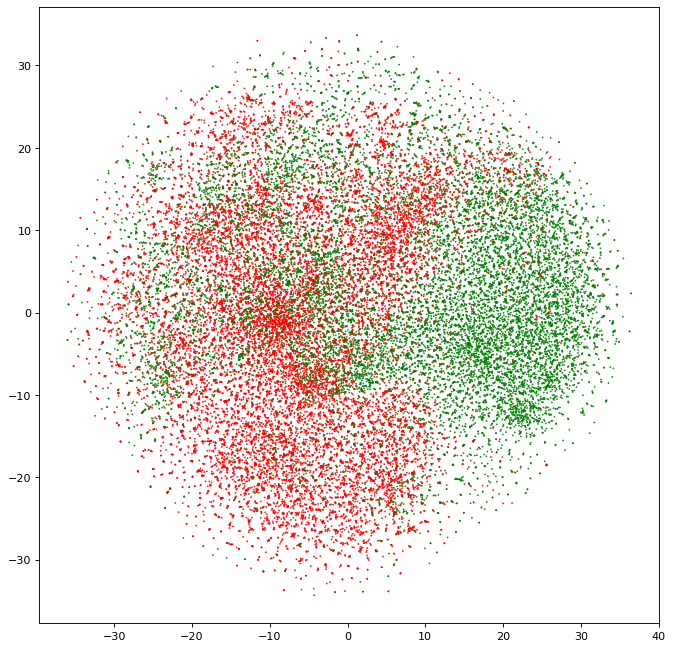

In [15]:
plt.figure(figsize=(10, 10), dpi=80)
y_col = ['green' if x == 'M'  else 'red' for x in y]
plt.scatter(t[:, 0], t[:, 1], c=y_col, s=0.3)

Пример мел-спектрограммы для мужского голоса:

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

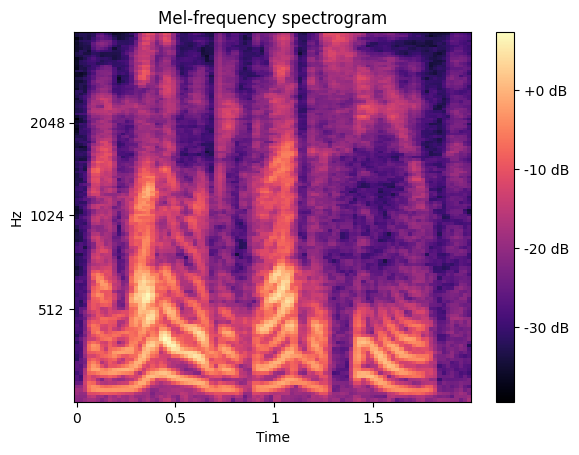

In [16]:
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(Xt[0].reshape(128, -1))
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=24000, fmin=20,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

Пример мел-спектрограммы для женского голоса:

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

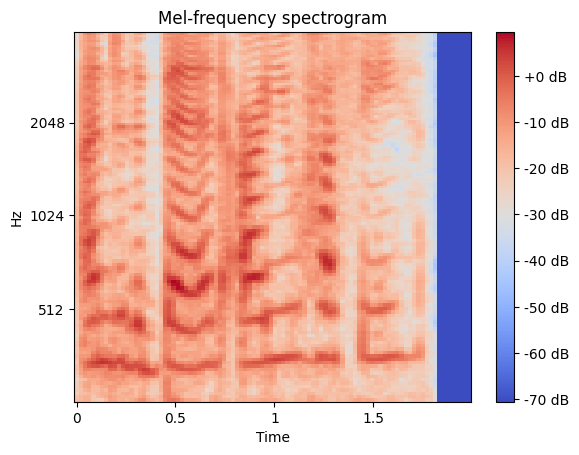

In [17]:
import librosa.display
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(Xt[100].reshape(128, -1))
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=24000, fmin=20,
                         fmax=4000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')